In [1]:
# a bunch of import statements
import numpy as np
import pandas as pd
import os
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from plotting import normalize_image, plot_image_array, plot_confusion_matrix, plot_model_history
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

# configure GPU memory options
import tensorflow as tf
tf.config.experimental.VirtualDeviceConfiguration(memory_limit=11264)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2023-03-22 15:56:50.766418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-22 15:56:50.766457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 15:56:53.272288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-22 15:56:53.272468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dl

In [2]:
# set various paths
data_path = os.path.join(sys.path[0], 'galaxy-zoo-the-galaxy-challenge/data')
training_path = os.path.join(data_path, 'images_training_rev1')
test_path = os.path.join(data_path, 'images_test_rev1')

# find file names
training_file_names = os.listdir(training_path)
test_file_names = os.listdir(test_path)

In [3]:
# load csv data
all_ones_benchmark = pd.read_csv(os.path.join(data_path, 'all_ones_benchmark.csv'), dtype=str)
all_zeros_benchmark = pd.read_csv(os.path.join(data_path, 'all_zeros_benchmark.csv'), dtype=str)
central_pixel_benchmark = pd.read_csv(os.path.join(data_path, 'central_pixel_benchmark.csv'), dtype=str)
training_solutions_rev1 = pd.read_csv(os.path.join(data_path, 'training_solutions_rev1.csv'), dtype=str)

In [4]:
# load training images + sol
training_img = []
training_img_sol = []

to_sample = np.random.permutation(61578)

# only save the (reshape_size, reshape_size) pixels in the center of the images
reshape_size = 200
edges = [int((424-reshape_size)/2), int((424-reshape_size)/2+reshape_size)]

for sample in tqdm(to_sample[:10000]):
    file = training_file_names[sample]
    
    # extract training image
    temp_img = cv2.imread(os.path.join(training_path, file))
    temp_img = temp_img[edges[0]:edges[1], edges[0]:edges[1], :]
    training_img.append(temp_img)
    
    # extract corresponding galaxy class probabilities from answer key
    galaxy_id = file[:6]
    sol_data = training_solutions_rev1.loc[training_solutions_rev1['GalaxyID'] == galaxy_id]
    training_img_sol.append(np.array(sol_data.iloc[0].tolist()[1:]))

# convert to numpy arrays
training_img = np.array(training_img)
training_img_sol = np.array(training_img_sol)

# load testing images
test_img = []
for file in tqdm(test_file_names[:1000]):
    temp_img = cv2.imread(os.path.join(test_path, file))
    temp_img = temp_img[edges[0]:edges[1], edges[0]:edges[1], :]
    test_img.append(temp_img)
test_img = np.array(test_img)

# class types (I'm sure there's a better way of doing this)
galaxy_class_labels = np.array(["Class1.1", "Class1.2", "Class1.3", "Class2.1", "Class2.2", "Class3.1", "Class3.2", 
                "Class4.1", "Class4.2", "Class5.1", "Class5.2", "Class5.3", "Class5.4", "Class6.1",
                "Class6.2", "Class7.1", "Class7.2", "Class7.3", "Class8.1", "Class8.2", "Class8.3",
                "Class8.4", "Class8.5", "Class8.6", "Class8.7", "Class9.1", "Class9.2", "Class9.3",
                "Class10.1", "Class10.2", "Class10.3", "Class11.1", "Class11.2", "Class11.3", "Class11.4",
                "Class11.5", "Class11.6"])

100%|██████████| 1000/1000 [00:02<00:00, 387.39it/s]


Number of samples in the training (8000); test (8000); and validation (2000) data sets


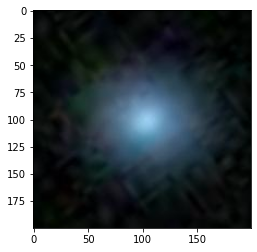

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


def reshape_arrays(data, labels, reshape_size):
    """reshape arrays for Keras"""
    data = data.reshape(-1, reshape_size, reshape_size, 3)
    labels = to_categorical(labels)
    return data, labels

# split the samples into training, validation and, test data sets:
train_frac = 0.8
val_frac = 0.2

# format the data for NN training
data_train_val, data_test, class_train_val, class_test = train_test_split(training_img, training_img_sol, test_size=None)

data_train, data_val, class_train, class_val = train_test_split(
    training_img, training_img_sol, test_size=val_frac / (train_frac + val_frac)
)

class_train = np.asarray(class_train, dtype=np.float64)

plt.imshow(data_train[0])

data_train, _ = reshape_arrays(data_train, class_train, reshape_size)

# print number of samples
print(
    f"Number of samples in the training ({data_train.shape[0]}); test ({data_train.shape[0]}); and validation ({data_val.shape[0]}) data sets"
)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

'''VGG6'''
def vgg6(input_shape=(424, 424, 3), n_classes: int = 37):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = Sequential(name="VGG6")
    model.add(Conv2D(16, (3, 3), activation="relu", input_shape=input_shape, name="conv1"))
    model.add(Conv2D(16, (3, 3), activation="relu", name="conv2"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), activation="relu", name="conv3"))
    model.add(Conv2D(32, (3, 3), activation="relu", name="conv4"))
    model.add(BatchNormalization(axis=3, name="bn_2"))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation="relu", name="fc_1"))
    model.add(Dropout(0.5))
    # output layer
    activation = "sigmoid"
    model.add(Dense(n_classes, activation=activation, name="fc_out"))

    return model

In [7]:
from keras import metrics

final_model = vgg6((reshape_size, reshape_size, 3))
final_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[metrics.mean_squared_error, "accuracy"])
final_model.summary()

Model: "VGG6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 198, 198, 16)      448       
                                                                 
 conv2 (Conv2D)              (None, 196, 196, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 98, 16)        0         
                                                                 
 conv3 (Conv2D)              (None, 96, 96, 32)        4640      
                                                                 
 conv4 (Conv2D)              (None, 94, 94, 32)        9248      
                                                              

2023-03-22 15:59:09.198001: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Train model for 20 epochs
n_epochs = 20
batch_size = 64

final_model_history = final_model.fit(
    data_train,
    class_train,
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=None,
    shuffle=True,
)
classes = final_model.predict(data_test)

Epoch 1/20
 81/125 [==================>...........] - ETA: 2:12 - loss: 0.5864 - mean_squared_error: 0.0844 - accuracy: 0.3484

2023-03-21 00:08:30.711590: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1348320000 exceeds 10% of free system memory.


79/79 [==============================] - 1s 11ms/step


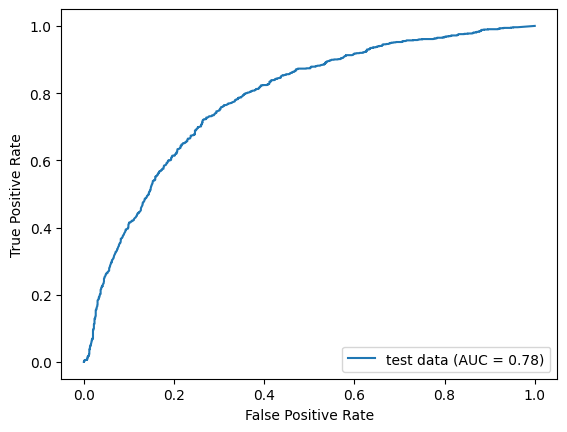

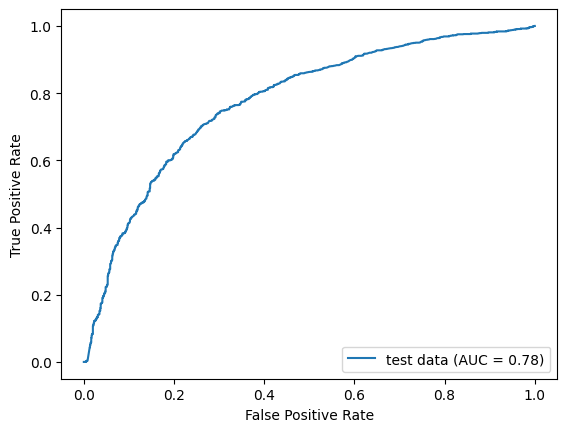

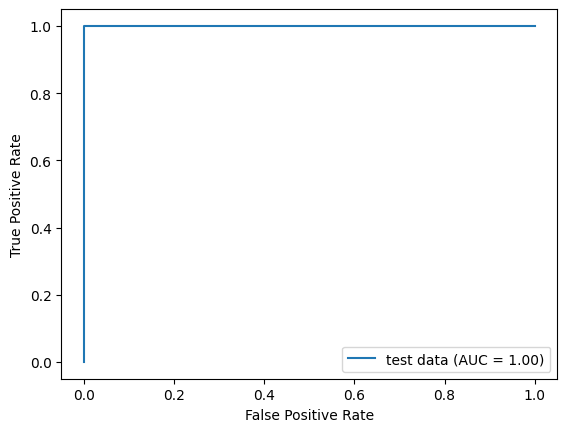

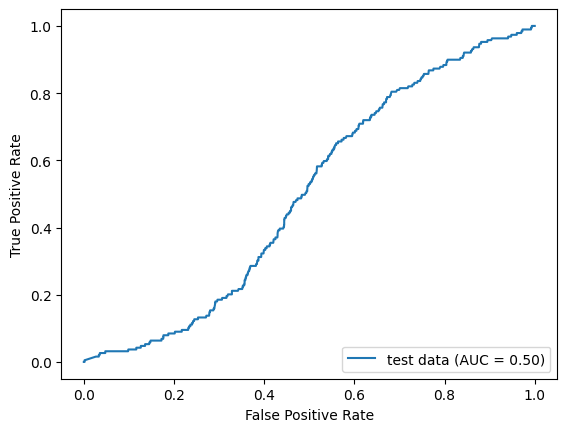

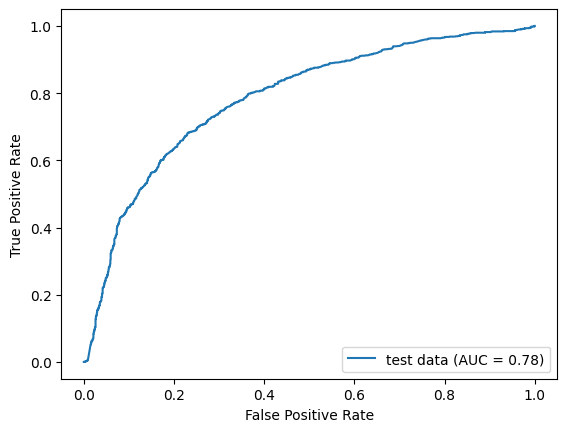

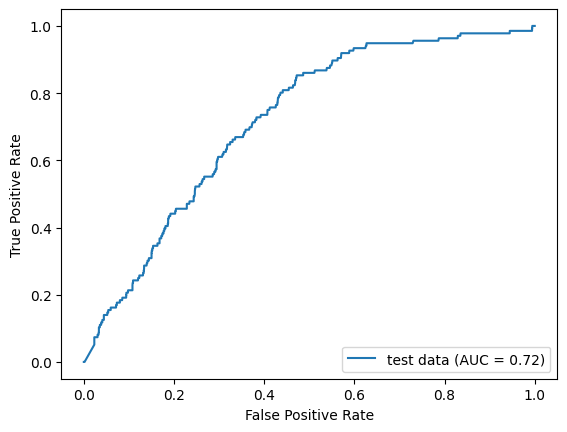

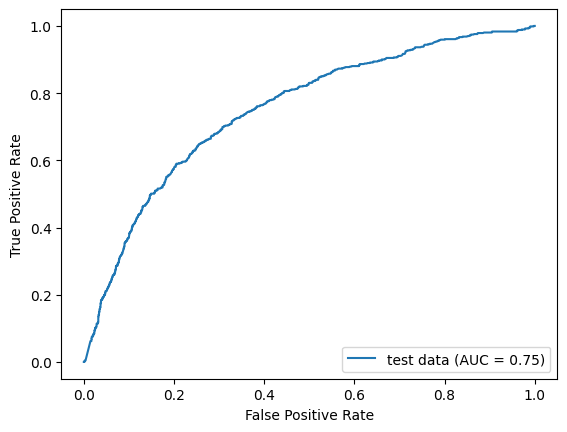

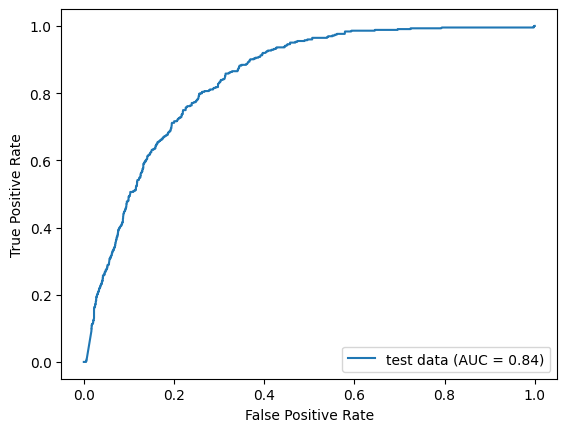

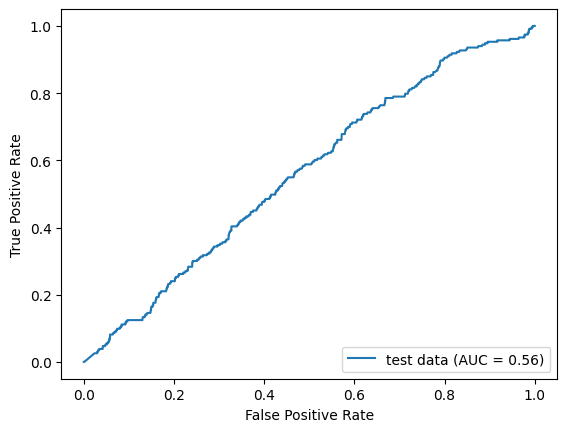

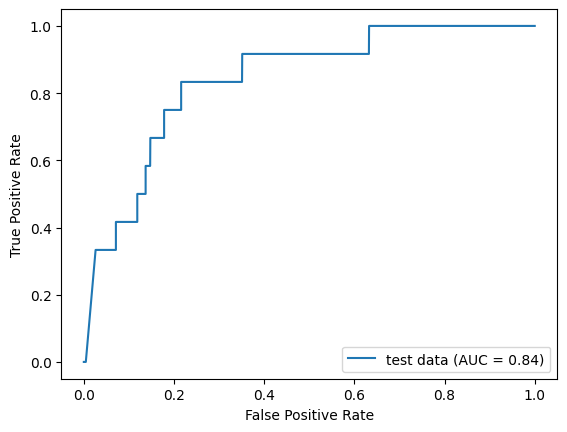

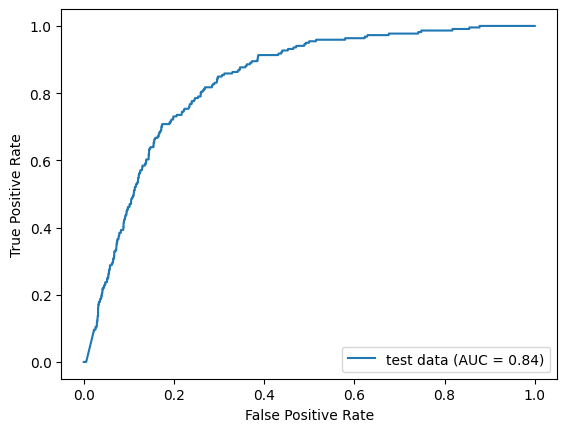

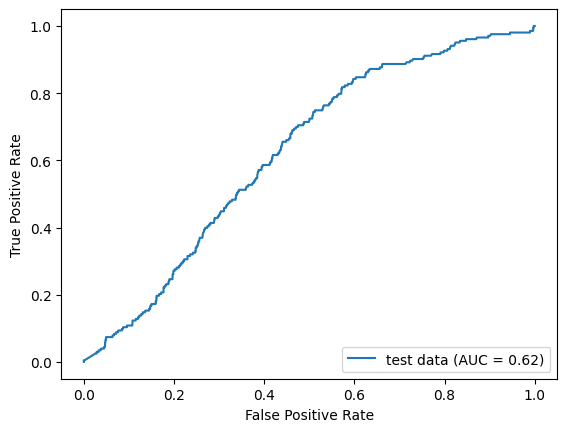

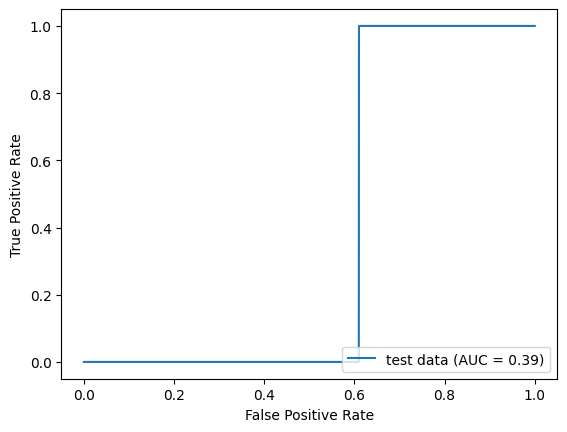

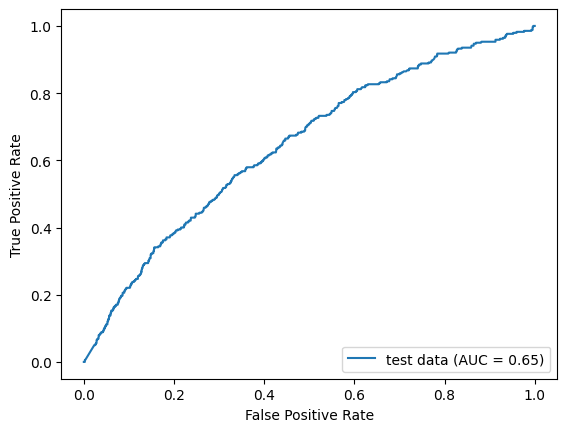

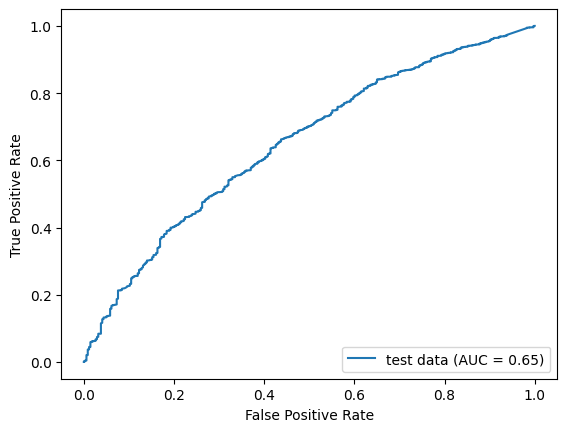

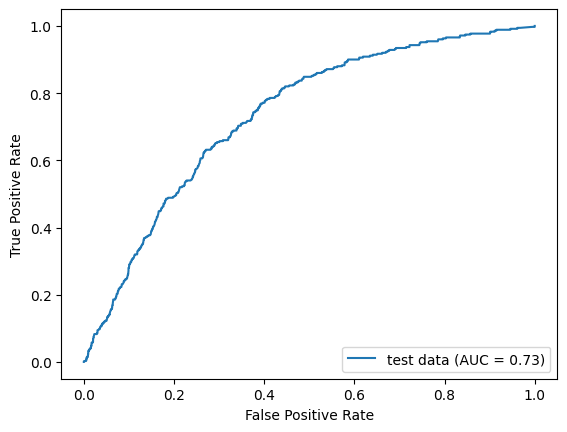

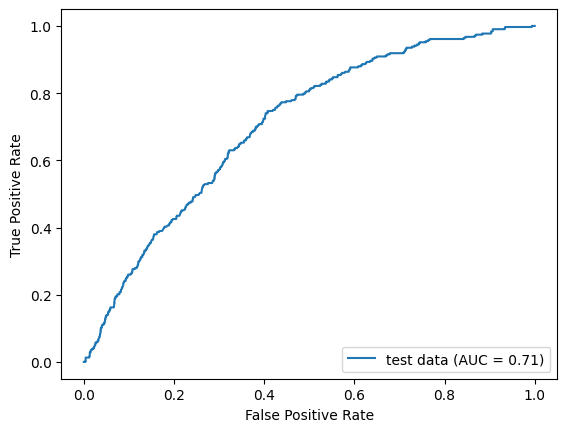

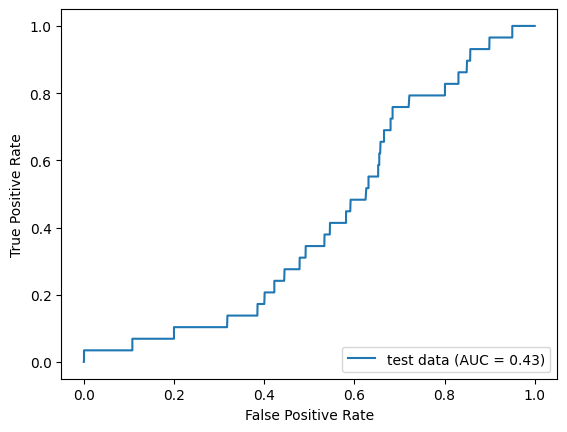

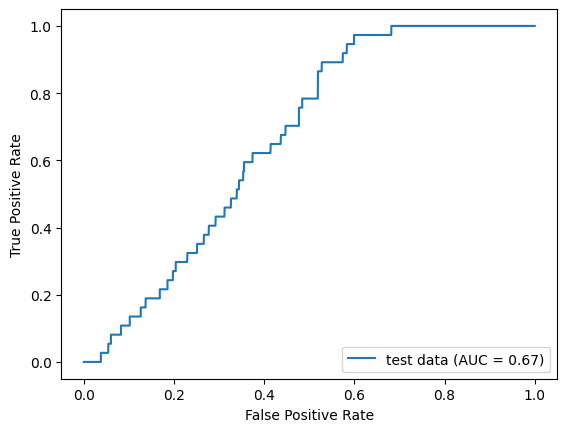

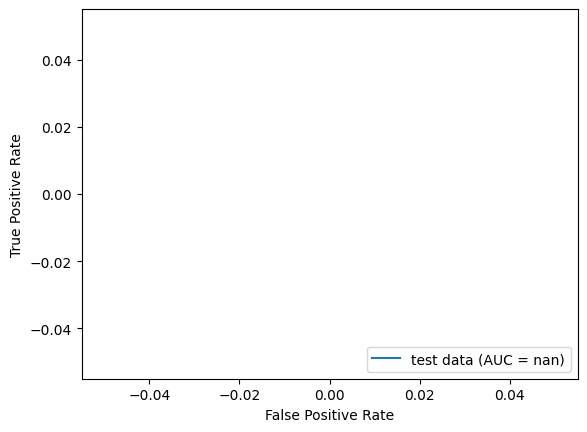

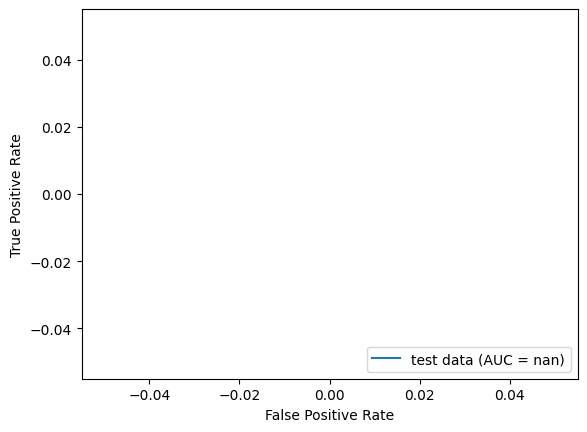

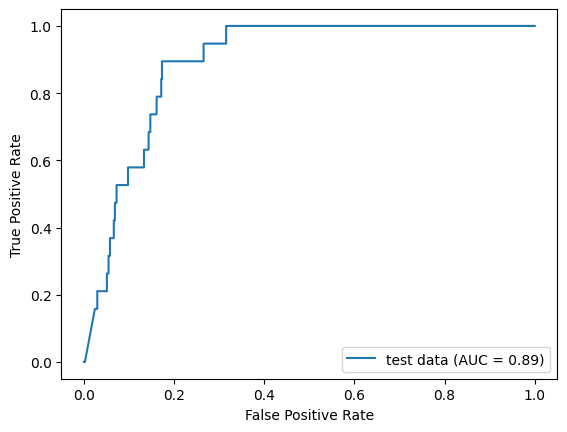

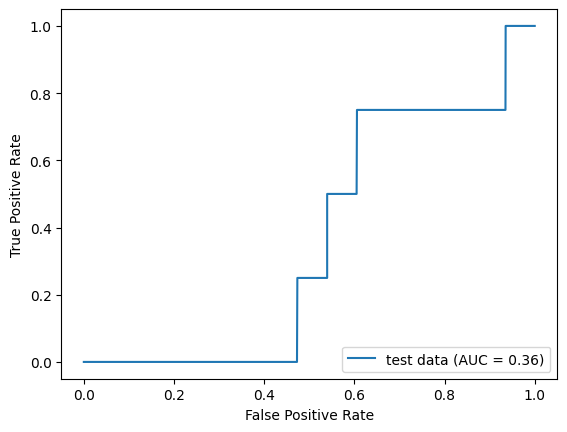

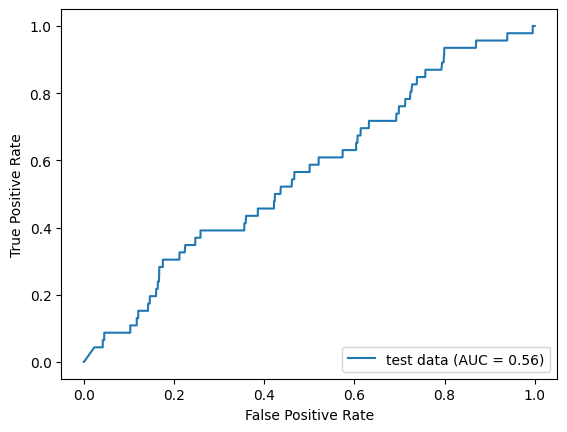

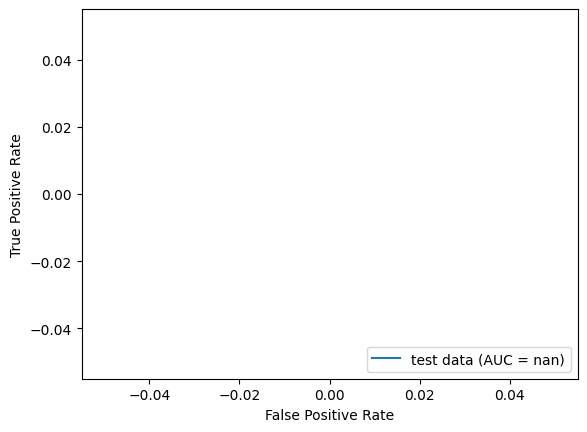

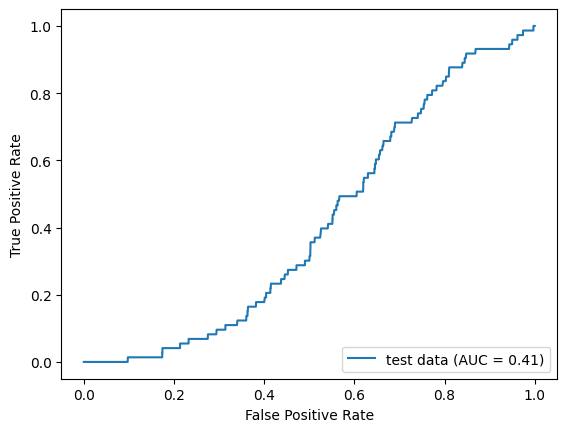

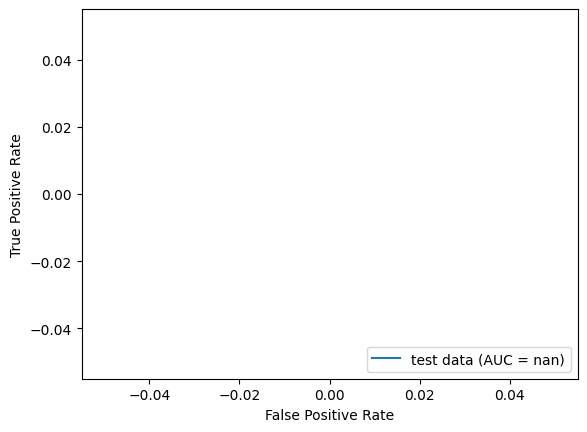

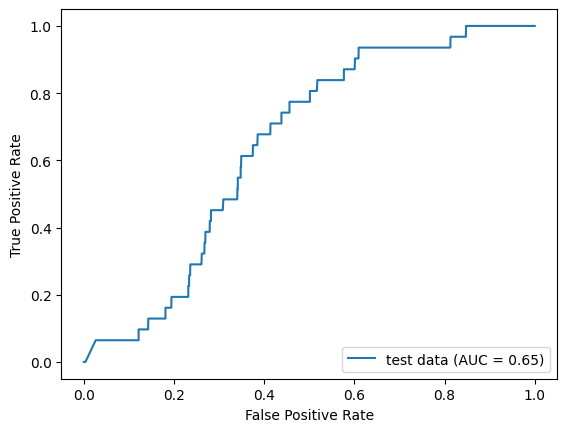

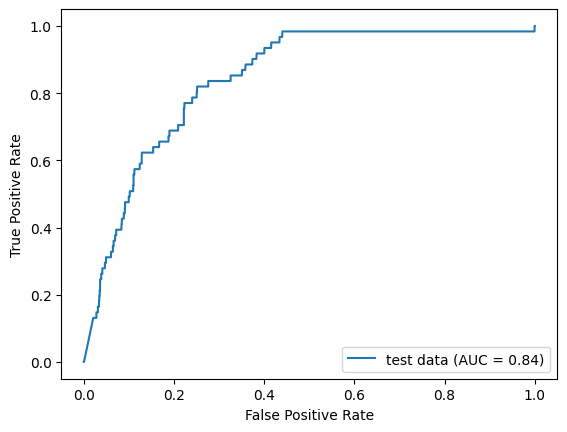

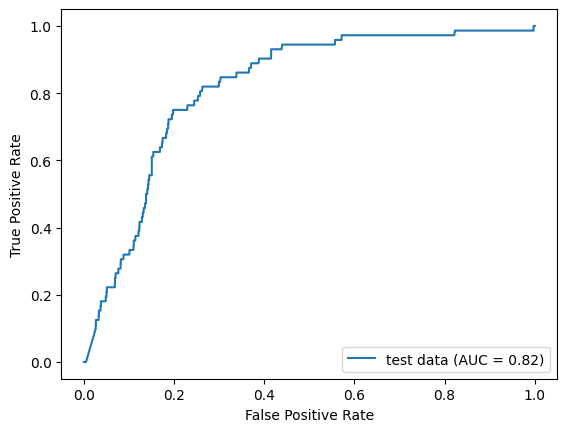

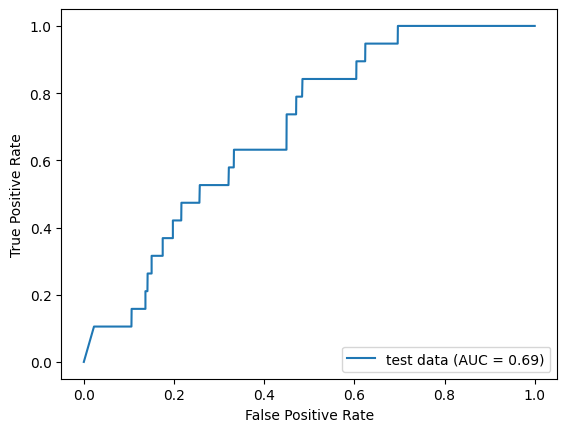

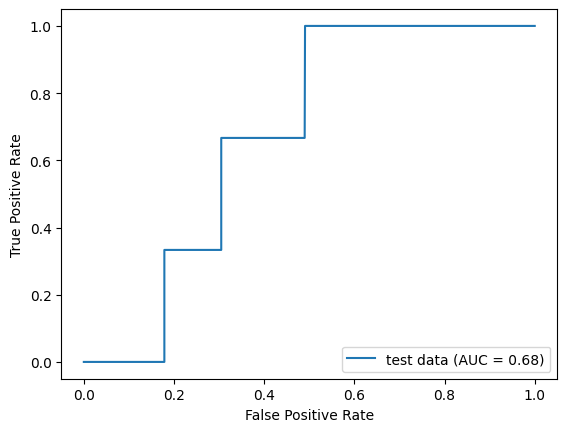

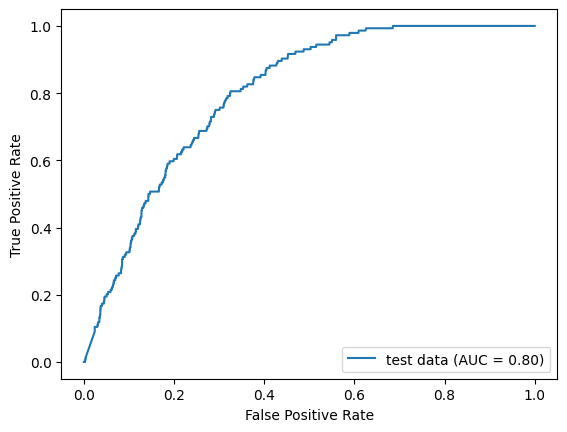

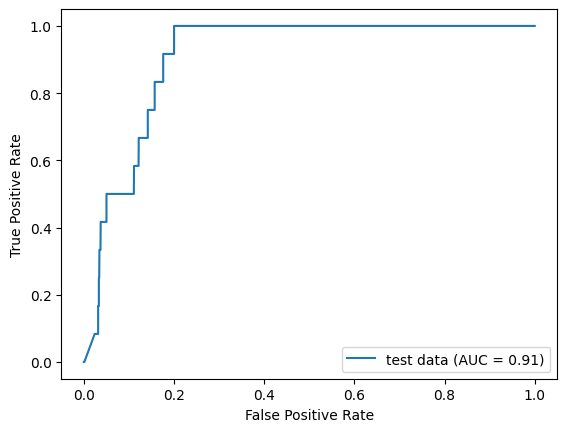

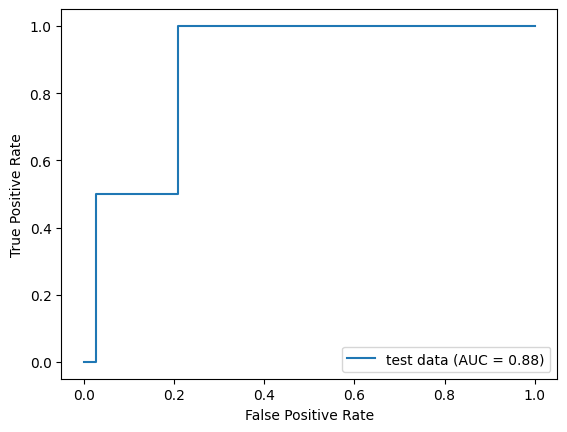

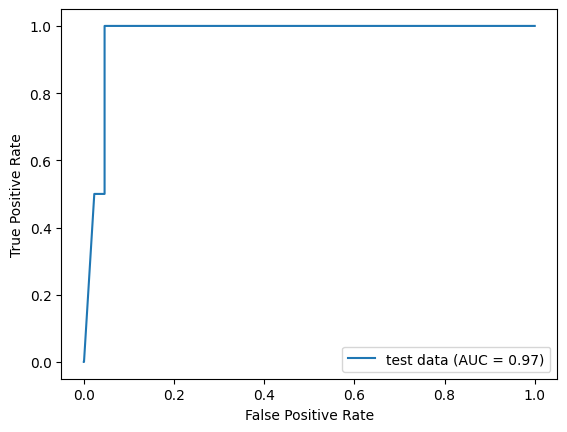

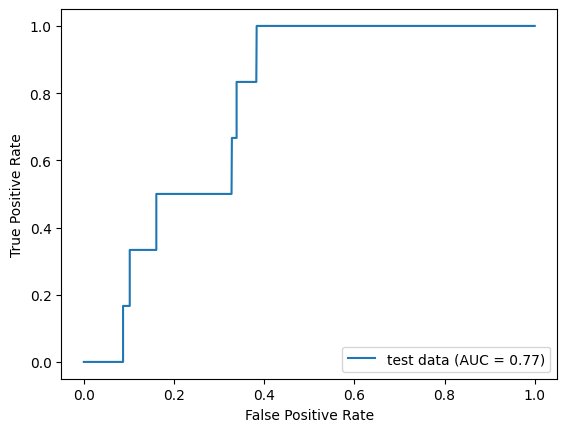

In [9]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# predict labels of test data
test_pred = final_model.predict(data_test)

# test labels
for i in range(0, class_test.shape[0]):
    for j in range(0, class_test.shape[1]):
        if float(class_test[i, j]) > 0.5:
            class_test[i, j] = 1;
        else:
            class_test[i, j] = 0

np.asarray(class_test, dtype = int)

# plot roc curve for test predictions w/ auc
for i in range(0, class_test.shape[1]):
    fpr, tpr, thresholds = roc_curve(class_test[:,i], test_pred[:,i], pos_label='1')
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = 'test data')
    display.plot()
    plt.savefig('auc_plots/plot_' + str(i) + '.png')